In [ ]:
# === PPO Training Log: High-quality Figures (300 DPI) ===
# Input CSV: ppo_training_log_static.csv
# Columns expected (case/space-insensitive match handled):
# "Time-steps", "Ep. Len", "Ep. Reward", "Policy Grad. Loss",
# "Value Loss", "Entropy Loss", "KL Divergence", "Total Loss"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# -------------------- Settings --------------------
from pathlib import Path
import os
import pandas as pd

FILENAME = "ppo_training_log_static.csv"

def resolve_csv(filename=FILENAME):
    """
    Find the CSV in common repo locations, or via env var SCAI_DATA.
    Works whether you run from repo root or from scripts/.
    """
    # 1) Optional override via environment variable (useful if data is outside Git)
    env_dir = os.getenv("SCAI_DATA")
    if env_dir:
        p = Path(env_dir).expanduser() / filename
        if p.exists():
            return p

    # 2) Try common relative locations
    cwd = Path.cwd()
    candidates = [
        cwd / filename,                 # .
        cwd / "data" / filename,        # ./data
        cwd / "Data" / filename,        # ./Data
        cwd.parent / filename,          # ..
        cwd.parent / "data" / filename, # ../data
        cwd.parent / "Data" / filename, # ../Data
    ]
    for p in candidates:
        if p.exists():
            return p

    tried = "\n".join(str(p) for p in candidates)
    raise FileNotFoundError(
        f"Could not find {filename}. Tried:\n{tried}\nCWD={cwd}\n"
        "Tip: put the file in your repo under 'data/' or set SCAI_DATA to its folder."
    )

CSV_PATH = resolve_csv()
print(f"[info] Using: {CSV_PATH}")

# Load the CSV
df_log = pd.read_csv(CSV_PATH)
print(df_log.shape, "rows x cols")


# Rolling window for smoothing (set to 1 to disable)
SMOOTH_WINDOW = 25

# Output filenames
OUT1 = "ppo_time_vs_reward_and_length.png"
OUT2 = "ppo_time_vs_pg_entropy_kl.png"
OUT3 = "ppo_time_vs_value_total_loss.png"

# Matplotlib text and layout settings for journals
plt.rcParams.update({
    "figure.figsize": (8, 5),      # good aspect ratio for papers
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.3,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "savefig.dpi": 300
})

# -------------------- Load & Normalize Columns --------------------
if not CSV_PATH.exists():
    raise FileNotFoundError(f"File not found: {CSV_PATH.resolve()}")

df = pd.read_csv(CSV_PATH)

# Normalize column names: strip spaces, lowercase
norm = {c: c.strip().lower() for c in df.columns}
df.rename(columns=norm, inplace=True)

# Mapping from many possible spellings to canonical keys
aliases = {
    "timesteps": ["time-steps", "timesteps", "time_steps", "time step", "time steps", "time"],
    "ep_len": ["ep. len", "ep len", "episode length", "ep_length", "episode_len"],
    "ep_reward": ["ep. reward", "ep reward", "episode reward", "episode_reward"],
    "pg_loss": ["policy grad. loss", "policy gradient loss", "policy_grad_loss", "pg loss", "pg_loss"],
    "value_loss": ["value loss", "val loss", "value_loss"],
    "entropy_loss": ["entropy loss", "entropy_loss"],
    "kl_div": ["kl divergence", "kl", "kl_divergence", "kl_div"],
    "total_loss": ["total loss", "total_loss"]
}

def resolve(col_aliases, frame_cols):
    for a in col_aliases:
        key = a.strip().lower()
        if key in frame_cols:
            return key
    return None

needed = {k: resolve(v, df.columns) for k, v in aliases.items()}

missing = [k for k, v in needed.items() if v is None and k not in ("ep_len",)]  # ep_len is optional
if missing:
    raise ValueError(f"Missing required columns for: {missing}. "
                     f"Found columns: {list(df.columns)}")

# Coerce numerics and drop rows with all-NaNs in key metrics
for col in [c for c in needed.values() if c is not None]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Sort by time
ts_col = needed["timesteps"]
df = df.sort_values(ts_col).reset_index(drop=True)

# Optional smoothing helper
def smooth(series, window=SMOOTH_WINDOW):
    if window is None or window <= 1:
        return series
    return series.rolling(window=window, min_periods=max(2, window//3), center=False).median()

# -------------------- Plot 1: Time-steps vs Ep. Reward & Ep. Length --------------------
fig, ax1 = plt.subplots()

# Left y-axis: Episode Reward
y1 = df[needed["ep_reward"]]
ax1.plot(df[ts_col], y1, alpha=0.35, linewidth=1.0, label="Episode Reward (raw)")
ax1.plot(df[ts_col], smooth(y1), linewidth=2.0, label=f"Episode Reward (median {SMOOTH_WINDOW})")
ax1.set_xlabel("Time steps")
ax1.set_ylabel("Episode Reward")

# Right y-axis: Episode Length (if available)
if needed["ep_len"] is not None and needed["ep_len"] in df:
    ax2 = ax1.twinx()
    y2 = df[needed["ep_len"]]
    ax2.plot(df[ts_col], y2, alpha=0.35, linewidth=1.0, linestyle=":", label="Episode Length (raw)")
    ax2.plot(df[ts_col], smooth(y2), linewidth=2.0, linestyle=":", label=f"Episode Length (median {SMOOTH_WINDOW})")
    ax2.set_ylabel("Episode Length")

    # Combine legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc="best", frameon=False)
else:
    ax1.legend(loc="best", frameon=False)

ax1.set_title("Time Steps vs Episode Reward and Episode Length")
fig.tight_layout()
fig.savefig(OUT1, bbox_inches="tight", dpi=300)
plt.close(fig)

# -------------------- Plot 2: Time-steps vs Policy Grad. Loss, Entropy Loss, KL Divergence --------------------
fig, ax = plt.subplots()

series_list = []
labels = []

for key, label in [("pg_loss", "Policy Gradient Loss"),
                   ("entropy_loss", "Entropy Loss"),
                   ("kl_div", "KL Divergence")]:
    col = needed.get(key)
    if col is None or col not in df:
        continue
    s_raw = df[col]
    s_sm = smooth(s_raw)
    ax.plot(df[ts_col], s_raw, alpha=0.25, linewidth=1.0, label=f"{label} (raw)")
    ax.plot(df[ts_col], s_sm, linewidth=2.0, label=f"{label} (median {SMOOTH_WINDOW})")

ax.set_xlabel("Time steps")
ax.set_ylabel("Loss / Divergence")
ax.set_title("Time Steps vs Policy Grad. Loss, Entropy Loss, and KL Divergence")
ax.legend(loc="best", frameon=False)
fig.tight_layout()
fig.savefig(OUT2, bbox_inches="tight", dpi=300)
plt.close(fig)

# -------------------- Plot 3: Time-steps vs Value Loss and Total Loss --------------------
fig, ax = plt.subplots()

for key, label, style in [("value_loss", "Value Loss", "-."),
                          ("total_loss", "Total Loss", "-")]:
    col = needed.get(key)
    if col is None or col not in df:
        continue
    s_raw = df[col]
    s_sm = smooth(s_raw)
    ax.plot(df[ts_col], s_raw, alpha=0.25, linewidth=1.0, linestyle=style, label=f"{label} (raw)")
    ax.plot(df[ts_col], s_sm, linewidth=2.0, linestyle=style, label=f"{label} (median {SMOOTH_WINDOW})")

ax.set_xlabel("Time steps")
ax.set_ylabel("Loss")
ax.set_title("Time Steps vs Value Loss and Total Loss")
ax.legend(loc="best", frameon=False)
fig.tight_layout()
fig.savefig(OUT3, bbox_inches="tight", dpi=300)
plt.close(fig)

print(f"Saved figures:\n - {OUT1}\n - {OUT2}\n - {OUT3}")


import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ------------- Settings -------------
from pathlib import Path
import os
import pandas as pd

FILENAME = "ppo_training_log_static.csv"

def resolve_csv(filename=FILENAME):
    """
    Find the CSV in common repo locations, or via env var SCAI_DATA.
    Works whether you run from repo root or from scripts/.
    """
    # 1) Optional override via environment variable (useful if data is outside Git)
    env_dir = os.getenv("SCAI_DATA")
    if env_dir:
        p = Path(env_dir).expanduser() / filename
        if p.exists():
            return p

    # 2) Try common relative locations
    cwd = Path.cwd()
    candidates = [
        cwd / filename,                 # .
        cwd / "data" / filename,        # ./data
        cwd / "Data" / filename,        # ./Data
        cwd.parent / filename,          # ..
        cwd.parent / "data" / filename, # ../data
        cwd.parent / "Data" / filename, # ../Data
    ]
    for p in candidates:
        if p.exists():
            return p

    tried = "\n".join(str(p) for p in candidates)
    raise FileNotFoundError(
        f"Could not find {filename}. Tried:\n{tried}\nCWD={cwd}\n"
        "Tip: put the file in your repo under 'data/' or set SCAI_DATA to its folder."
    )

CSV_PATH = resolve_csv()
print(f"[info] Using: {CSV_PATH}")

# Load the CSV
df_log = pd.read_csv(CSV_PATH)
print(df_log.shape, "rows x cols")
  # change if needed

OUT1_PNG = "ppo_reward_length.png"
OUT2_PNG = "ppo_pg_entropy_kl.png"
OUT3_PNG = "ppo_value_total_loss.png"

OUT1_PDF = "ppo_reward_length.pdf"
OUT2_PDF = "ppo_pg_entropy_kl.pdf"
OUT3_PDF = "ppo_value_total_loss.pdf"

# Global Matplotlib settings for publication figures
plt.rcParams.update({
    "figure.figsize": (8, 5),   # good aspect ratio for papers
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.3,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "savefig.dpi": 300,         # 300 DPI on save
})

# ------------- Load -------------
if not CSV_PATH.exists():
    raise FileNotFoundError(f"Could not find CSV at: {CSV_PATH.resolve()}")

df = pd.read_csv(CSV_PATH)

# Normalize and map columns so minor naming differences won't break the code
df.columns = [c.strip().lower() for c in df.columns]
col_map = {
    "time-steps": "timesteps",
    "time steps": "timesteps",
    "time": "timesteps",
    "ep. len": "ep_len",
    "ep len": "ep_len",
    "episode length": "ep_len",
    "ep. reward": "ep_reward",
    "ep reward": "ep_reward",
    "episode reward": "ep_reward",
    "policy grad. loss": "pg_loss",
    "policy gradient loss": "pg_loss",
    "value loss": "value_loss",
    "entropy loss": "entropy_loss",
    "kl divergence": "kl_div",
    "total loss": "total_loss",
}
df.rename(columns={k: v for k, v in col_map.items() if k in df.columns}, inplace=True)

# Ensure numeric (non-numeric → NaN)
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Check required columns
required = ["timesteps", "ep_reward"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}. "
                     f"Available columns: {list(df.columns)}")

# Sort by time steps (if not already)
df = df.sort_values("timesteps").reset_index(drop=True)

# ------------- Plot 1: Time steps vs Episode Reward & Episode Length -------------
fig1, ax1 = plt.subplots()
ax1.plot(df["timesteps"], df["ep_reward"], label="Episode Reward", linewidth=2)
ax1.set_xlabel("Time steps")
ax1.set_ylabel("Episode Reward")

# Secondary axis for Episode Length if available
if "ep_len" in df.columns:
    ax2 = ax1.twinx()
    ax2.plot(df["timesteps"], df["ep_len"], label="Episode Length", linewidth=2, linestyle="--")
    ax2.set_ylabel("Episode Length")
    # Merge legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc="best", frameon=False)
else:
    ax1.legend(loc="best", frameon=False)

ax1.set_title("Time Steps vs Episode Reward and Episode Length")
fig1.tight_layout()
plt.show()
fig1.savefig(OUT1_PNG, bbox_inches="tight")
fig1.savefig(OUT1_PDF, bbox_inches="tight")

# ------------- Plot 2: Time steps vs PG Loss, Entropy Loss, KL Divergence -------------
fig2, ax = plt.subplots()
plotted_any = False

if "pg_loss" in df.columns:
    ax.plot(df["timesteps"], df["pg_loss"], label="Policy Gradient Loss", linewidth=2)
    plotted_any = True
if "entropy_loss" in df.columns:
    ax.plot(df["timesteps"], df["entropy_loss"], label="Entropy Loss", linewidth=2)
    plotted_any = True
if "kl_div" in df.columns:
    ax.plot(df["timesteps"], df["kl_div"], label="KL Divergence", linewidth=2)
    plotted_any = True

if not plotted_any:
    raise ValueError("None of the loss columns were found: pg_loss, entropy_loss, kl_div")

ax.set_xlabel("Time steps")
ax.set_ylabel("Loss / Divergence")
ax.set_title("Time Steps vs Policy Gradient Loss, Entropy Loss, KL Divergence")
ax.legend(loc="best", frameon=False)
fig2.tight_layout()
plt.show()
fig2.savefig(OUT2_PNG, bbox_inches="tight")
fig2.savefig(OUT2_PDF, bbox_inches="tight")

# ------------- Plot 3: Time steps vs Value Loss & Total Loss -------------
fig3, ax = plt.subplots()
plotted_any = False

if "value_loss" in df.columns:
    ax.plot(df["timesteps"], df["value_loss"], label="Value Loss", linewidth=2)
    plotted_any = True
if "total_loss" in df.columns:
    ax.plot(df["timesteps"], df["total_loss"], label="Total Loss", linewidth=2)
    plotted_any = True

if not plotted_any:
    raise ValueError("None of the loss columns were found: value_loss, total_loss")

ax.set_xlabel("Time steps")
ax.set_ylabel("Loss")
ax.set_title("Time Steps vs Value Loss and Total Loss")
ax.legend(loc="best", frameon=False)
fig3.tight_layout()
plt.show()
fig3.savefig(OUT3_PNG, bbox_inches="tight")
fig3.savefig(OUT3_PDF, bbox_inches="tight")

print("Saved:")
print(f" - {OUT1_PNG} | {OUT1_PDF}")
print(f" - {OUT2_PNG} | {OUT2_PDF}")
print(f" - {OUT3_PNG} | {OUT3_PDF}")


Saved figures:
 - ppo_time_vs_reward_and_length.png
 - ppo_time_vs_pg_entropy_kl.png
 - ppo_time_vs_value_total_loss.png


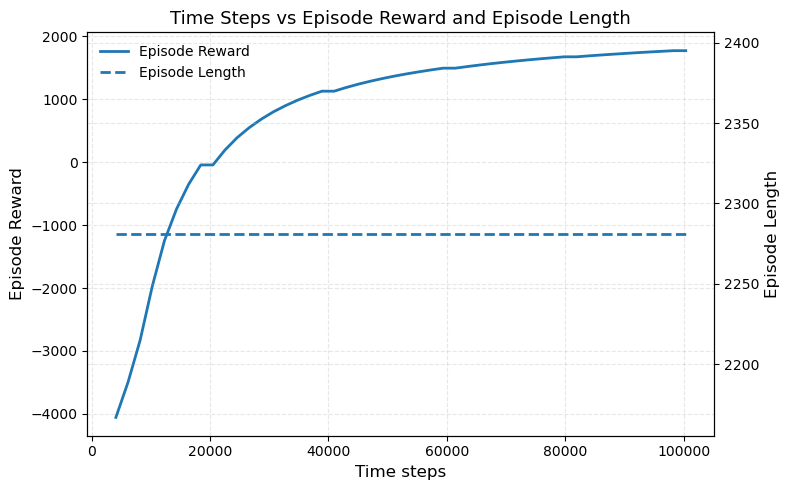

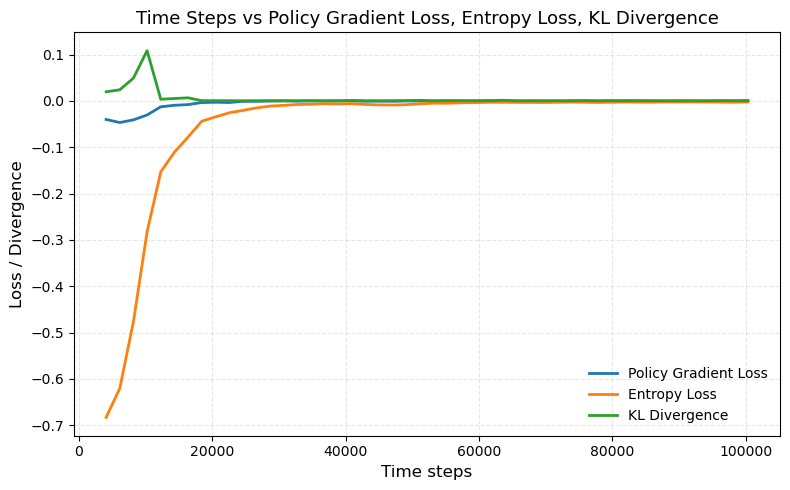

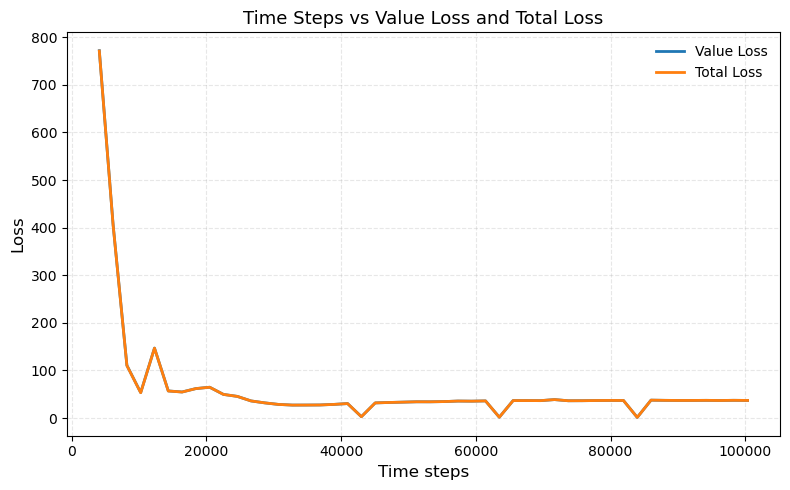

Saved:
 - ppo_reward_length.png | ppo_reward_length.pdf
 - ppo_pg_entropy_kl.png | ppo_pg_entropy_kl.pdf
 - ppo_value_total_loss.png | ppo_value_total_loss.pdf


In [3]:
# === PPO Training Log → Journal-ready Figures (300 DPI, no smoothing) ===
# How to use:
# 1) Put your CSV in the same folder as the notebook OR set CSV_PATH below to its full path.
# 2) Run this cell. It will DISPLAY the three figures AND SAVE them as PNG (300 DPI) and PDF.

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ------------- Settings -------------
CSV_PATH = Path("ppo_training_log_static.csv")  # change if needed

OUT1_PNG = "ppo_reward_length.png"
OUT2_PNG = "ppo_pg_entropy_kl.png"
OUT3_PNG = "ppo_value_total_loss.png"

OUT1_PDF = "ppo_reward_length.pdf"
OUT2_PDF = "ppo_pg_entropy_kl.pdf"
OUT3_PDF = "ppo_value_total_loss.pdf"

# Global Matplotlib settings for publication figures
plt.rcParams.update({
    "figure.figsize": (8, 5),   # good aspect ratio for papers
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.3,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "savefig.dpi": 300,         # 300 DPI on save
})

# ------------- Load -------------
if not CSV_PATH.exists():
    raise FileNotFoundError(f"Could not find CSV at: {CSV_PATH.resolve()}")

df = pd.read_csv(CSV_PATH)

# Normalize and map columns so minor naming differences won't break the code
df.columns = [c.strip().lower() for c in df.columns]
col_map = {
    "time-steps": "timesteps",
    "time steps": "timesteps",
    "time": "timesteps",
    "ep. len": "ep_len",
    "ep len": "ep_len",
    "episode length": "ep_len",
    "ep. reward": "ep_reward",
    "ep reward": "ep_reward",
    "episode reward": "ep_reward",
    "policy grad. loss": "pg_loss",
    "policy gradient loss": "pg_loss",
    "value loss": "value_loss",
    "entropy loss": "entropy_loss",
    "kl divergence": "kl_div",
    "total loss": "total_loss",
}
df.rename(columns={k: v for k, v in col_map.items() if k in df.columns}, inplace=True)

# Ensure numeric (non-numeric → NaN)
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Check required columns
required = ["timesteps", "ep_reward"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}. "
                     f"Available columns: {list(df.columns)}")

# Sort by time steps (if not already)
df = df.sort_values("timesteps").reset_index(drop=True)

# ------------- Plot 1: Time steps vs Episode Reward & Episode Length -------------
fig1, ax1 = plt.subplots()
ax1.plot(df["timesteps"], df["ep_reward"], label="Episode Reward", linewidth=2)
ax1.set_xlabel("Time steps")
ax1.set_ylabel("Episode Reward")

# Secondary axis for Episode Length if available
if "ep_len" in df.columns:
    ax2 = ax1.twinx()
    ax2.plot(df["timesteps"], df["ep_len"], label="Episode Length", linewidth=2, linestyle="--")
    ax2.set_ylabel("Episode Length")
    # Merge legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc="best", frameon=False)
else:
    ax1.legend(loc="best", frameon=False)

ax1.set_title("Time Steps vs Episode Reward and Episode Length")
fig1.tight_layout()
plt.show()
fig1.savefig(OUT1_PNG, bbox_inches="tight")
fig1.savefig(OUT1_PDF, bbox_inches="tight")

# ------------- Plot 2: Time steps vs PG Loss, Entropy Loss, KL Divergence -------------
fig2, ax = plt.subplots()
plotted_any = False

if "pg_loss" in df.columns:
    ax.plot(df["timesteps"], df["pg_loss"], label="Policy Gradient Loss", linewidth=2)
    plotted_any = True
if "entropy_loss" in df.columns:
    ax.plot(df["timesteps"], df["entropy_loss"], label="Entropy Loss", linewidth=2)
    plotted_any = True
if "kl_div" in df.columns:
    ax.plot(df["timesteps"], df["kl_div"], label="KL Divergence", linewidth=2)
    plotted_any = True

if not plotted_any:
    raise ValueError("None of the loss columns were found: pg_loss, entropy_loss, kl_div")

ax.set_xlabel("Time steps")
ax.set_ylabel("Loss / Divergence")
ax.set_title("Time Steps vs Policy Gradient Loss, Entropy Loss, KL Divergence")
ax.legend(loc="best", frameon=False)
fig2.tight_layout()
plt.show()
fig2.savefig(OUT2_PNG, bbox_inches="tight")
fig2.savefig(OUT2_PDF, bbox_inches="tight")

# ------------- Plot 3: Time steps vs Value Loss & Total Loss -------------
fig3, ax = plt.subplots()
plotted_any = False

if "value_loss" in df.columns:
    ax.plot(df["timesteps"], df["value_loss"], label="Value Loss", linewidth=2)
    plotted_any = True
if "total_loss" in df.columns:
    ax.plot(df["timesteps"], df["total_loss"], label="Total Loss", linewidth=2)
    plotted_any = True

if not plotted_any:
    raise ValueError("None of the loss columns were found: value_loss, total_loss")

ax.set_xlabel("Time steps")
ax.set_ylabel("Loss")
ax.set_title("Time Steps vs Value Loss and Total Loss")
ax.legend(loc="best", frameon=False)
fig3.tight_layout()
plt.show()
fig3.savefig(OUT3_PNG, bbox_inches="tight")
fig3.savefig(OUT3_PDF, bbox_inches="tight")

print("Saved:")
print(f" - {OUT1_PNG} | {OUT1_PDF}")
print(f" - {OUT2_PNG} | {OUT2_PDF}")
print(f" - {OUT3_PNG} | {OUT3_PDF}")
